In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, AveragePooling2D
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, ZeroPadding2D, Input, add
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import csv
import cv2
from itertools import chain 

Using TensorFlow backend.


In [2]:
"""
Define constants and global variables
"""

num_bins = 25
sample_per_bin = 3000

image_center_path = []
image_left_path = []
image_right_path = []
steering_values = []
steering_values_all = []
steering_values_aug = []

IMG_HEIGHT = 0
IMG_WIDTH = 0


PATH = "./IMG/"

In [5]:
"""
CNN Model of depth 25, with below architecture. This layer has no shortcuts to propagate error to lower layers.
1: Con with 32 filters of kernel size 7, padding as valid with 1 stride. Input shape is 80*320. Activation as ELU (Better than RELU)
2: A batch normalization layer. 
3: Con with 32 filters of kernel size 7, padding as valid with 1 stride. Activation as ELU (Better than RELU)
4: A batch normalization layer. 
5: A MAX pool layer with kernel size of 2.

6: Con with 64 filters of kernel size 5, padding as valid with 1 stride. Activation as ELU (Better than RELU)
7: A batch normalization layer. 
8: Con with 64 filters of kernel size 5, padding as valid with 1 stride. Activation as ELU (Better than RELU)
9: A batch normalization layer. 
10: A MAX pool layer with kernel size of 2.

11: Con with 128 filters of kernel size 3, padding as valid with 1 stride. Activation as ELU (Better than RELU)
12: A batch normalization layer. 
13: Con with 128 filters of kernel size 3, padding as valid with 1 stride. Activation as ELU (Better than RELU)
14: A batch normalization layer. 
15: A MAX pool layer with kernel size of 2.
16: Con with 128 filters of kernel size 3, padding as valid with 1 stride. Activation as ELU (Better than RELU)
17: A batch normalization layer. 
18: Flatten layer to convert node to linear ANN
19: A dense layer with 200 nodes and activation as ELU
20: A dropout layer with dropout of 30
21: A dense layer with 200 nodes and activation as ELU
22: A dropout layer with dropout of 30
23: A dense layer with 100 nodes and activation as ELU
24: A dense layer with 50 nodes and activation as Linear
25: A dense layer with 1 nodes and activation as Linear for final steering values.
"""

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=7, padding='valid', strides=(1,1), activation='elu', input_shape=(80,320,3), kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=7, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=5, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=5, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', strides=(1,1), activation='elu',  kernel_initializer='glorot_normal'))
model.add(BatchNormalization())

model.add(Flatten())
#model.add(Dropout(0.3))
model.add(Dense(200, activation='elu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='elu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.3))
#model.add(Dense(200, activation='linear', kernel_initializer='glorot_normal'))
model.add(Dense(100, activation='elu', kernel_initializer='glorot_normal'))
model.add(Dense(50, activation='linear', kernel_initializer='glorot_normal'))
#model.add(Dropout(0.3))

model.add(Dense(1, activation='linear', kernel_initializer='glorot_normal'))


In [4]:
print(len(model.layers))
model.summary()

25
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 314, 32)       4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 314, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 308, 32)       50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 308, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 154, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 150, 64)       51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 150, 64)     

In [7]:
"""
Read CSV file to load images.
"""

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv("driving_log.csv", names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\center_2019_11_21_18_15_23_918.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\left_2019_11_21_18_15_23_918.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\right_2019_11_21_18_15_23_918.jpg,0.0,0.0,0.0,1.180054
1,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\center_2019_11_21_18_15_23_993.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\left_2019_11_21_18_15_23_993.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\right_2019_11_21_18_15_23_993.jpg,0.0,0.0,0.0,1.169385
2,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\center_2019_11_21_18_15_24_070.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\left_2019_11_21_18_15_24_070.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\right_2019_11_21_18_15_24_070.jpg,0.0,0.0,0.0,1.158803
3,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\center_2019_11_21_18_15_24_145.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\left_2019_11_21_18_15_24_145.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\right_2019_11_21_18_15_24_145.jpg,0.0,0.0,0.0,1.148307
4,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\center_2019_11_21_18_15_24_219.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\left_2019_11_21_18_15_24_219.jpg,C:\Users\gasati\Documents\GitHub\Udacity_Self_Drive\SDC-ND\IMG\right_2019_11_21_18_15_24_219.jpg,0.0,0.0,0.0,1.137896


In [6]:
len(data)

40109

In [7]:
"""
Read file names and update values which have just required file name and all path removed from it.
"""
def get_file_name(file_loc):

    #print(file_loc)
    head, tail = ntpath.split(file_loc)
    return tail

data['center'] = data['center'].apply(get_file_name)
data['left'] = data['left'].apply(get_file_name)
data['right'] = data['right'].apply(get_file_name)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_11_21_18_15_23_918.jpg,left_2019_11_21_18_15_23_918.jpg,right_2019_11_21_18_15_23_918.jpg,0.0,0.0,0.0,1.180054
1,center_2019_11_21_18_15_23_993.jpg,left_2019_11_21_18_15_23_993.jpg,right_2019_11_21_18_15_23_993.jpg,0.0,0.0,0.0,1.169385
2,center_2019_11_21_18_15_24_070.jpg,left_2019_11_21_18_15_24_070.jpg,right_2019_11_21_18_15_24_070.jpg,0.0,0.0,0.0,1.158803
3,center_2019_11_21_18_15_24_145.jpg,left_2019_11_21_18_15_24_145.jpg,right_2019_11_21_18_15_24_145.jpg,0.0,0.0,0.0,1.148307
4,center_2019_11_21_18_15_24_219.jpg,left_2019_11_21_18_15_24_219.jpg,right_2019_11_21_18_15_24_219.jpg,0.0,0.0,0.0,1.137896


In [8]:
len(data)

40109

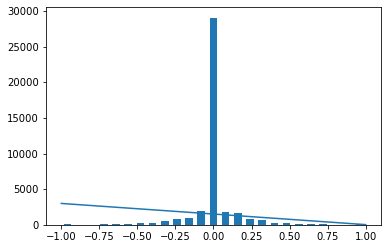

In [9]:
"""
Plot histogram of steering angles. Need to have a balance data else model will be biased towards steering angle as 0.
"""
def show_histogram(data,num_bins,sample_per_bin):
    histogram,bins = np.histogram(data, num_bins)
    #print(bins[::-1])
    #print(bins)
    bin_center = (bins[:-1] + bins[1:]) * 0.5
    #print(bin_center)
    plt.bar(bin_center, histogram, width=0.05)
    plt.plot((np.min(data), np.max(data)), (sample_per_bin, num_bins))
    
    return histogram,bins

histogram_all_data,bins_all_data = show_histogram(data['steering'],num_bins,sample_per_bin)

In [10]:
"""
This limits number of samples for each steering angles in training data. Data is not removed here, just a list of indexes
is made.
"""

def cleanup_data(data_col, num_bins, bins, sample_per_bin):
    remove_list = []
    for j in range(num_bins):
        in_bin = []
        #print("bin rnage is ",bins[j], bins[j+1])
        for i in range(len(data_col)):
            if data_col[i] >= bins[j] and data_col[i] <= bins[j+1]:
                #print("adding",data_col[i])
                in_bin.append(i)
        #print("before",len(in_bin) )
        in_bin = shuffle(in_bin)
        in_bin = in_bin[sample_per_bin:]
        #print("after", len(in_bin))
        remove_list.extend(in_bin)
            
    return remove_list
            
        
remove_idx = cleanup_data(data['steering'],num_bins, bins_all_data, sample_per_bin)

In [11]:
len(remove_idx)

26085

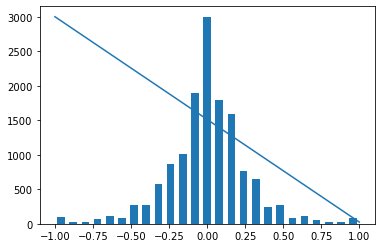

In [12]:
"""
This drops data from our sample space, now we have limited data noramlly distributed values for steering angles.
"""
def drop_data(data,index_list):
    return data.drop(data.index[index_list], inplace=False)

data_bin_limit = drop_data(data, remove_idx)

histogram_limit_data,bins_limit_data = show_histogram(data_bin_limit['steering'],num_bins,sample_per_bin)

In [13]:
"""
Check data after dropping all path extentions in file name.
"""
data_bin_limit.head()

,center,left,right,steering,throttle,reverse,speed
11,center_2019_11_21_18_15_24_754.jpg,left_2019_11_21_18_15_24_754.jpg,right_2019_11_21_18_15_24_754.jpg,0.00,0.179529,0.0,1.168961
23,center_2019_11_21_18_15_25_660.jpg,left_2019_11_21_18_15_25_660.jpg,right_2019_11_21_18_15_25_660.jpg,-0.15,1.000000,0.0,10.589150
24,center_2019_11_21_18_15_25_734.jpg,left_2019_11_21_18_15_25_734.jpg,right_2019_11_21_18_15_25_734.jpg,-0.30,1.000000,0.0,11.227080
25,center_2019_11_21_18_15_25_811.jpg,left_2019_11_21_18_15_25_811.jpg,right_2019_11_21_18_15_25_811.jpg,-0.50,1.000000,0.0,11.872730
31,center_2019_11_21_18_15_26_262.jpg,left_2019_11_21_18_15_26_262.jpg,right_2019_11_21_18_15_26_262.jpg,0.00,1.000000,0.0,16.829440


In [14]:
"""
Load file names in list for each image side. Left,center,right for corresponding images.
"""

def load_selected_data(data, path_dir = PATH):
    
    image_center_path.clear()
    image_left_path.clear()
    image_right_path.clear()
    
    for i in range(len(data)):
        
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        steering_values.append(indexed_data[3])
        image_center_path.append(os.path.join(path_dir,center))
        image_left_path.append(os.path.join(path_dir,left))
        image_right_path.append(os.path.join(path_dir,right))
        #print(center, left, right)
    
load_selected_data(data_bin_limit)

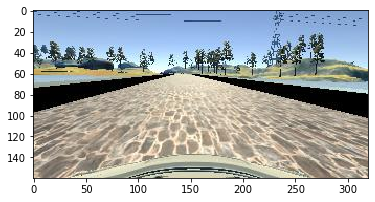

In [15]:
"""
Check a random image.
"""
plt.imshow(plt.imread(image_center_path[0]))

In [16]:
"""
Set global variables for image size.
"""
def set_img_size():
    ## all images are of equal size
    global IMG_HEIGHT ,IMG_WIDTH
    IMG_HEIGHT, IMG_WIDTH = plt.imread(image_center_path[0]).shape[0],plt.imread(image_center_path[0]).shape[1]

print(IMG_HEIGHT,IMG_WIDTH)
set_img_size()
print(IMG_HEIGHT,IMG_WIDTH)

0 0
160 320


In [17]:
"""
Helper functions for processing
"""

def crop(img):
"""
Crop image to required size. Top and bottom images are cropped as it contains sky/trees (junk data) and car's 
dash board.
"""    
    img = plt.imread(img)
    img = img[60: IMG_HEIGHT -20, : ,:]
    
    return img


def convert_2_YUV(img):
"""
As per Nvidia's Paper, YUV is much better than RBG color space.
"""    
    
    yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    
    return yuv_img

def blur_image(img):
"""
Add Gaussian blur to reduce random high frequency in images.
"""    
    
    blur_img = cv2.GaussianBlur(img, (3,3),0)
    
    return blur_img

def zoom_image(img):
"""
Zoom image randomly.
"""    

    zoom = iaa.Affine(scale=(.9,1.3))
    image = zoom.augment_image(img)
    
    return image

def pan_image(img):
"""
Randomly squeeze images from 90 to 110 in both X and Y
""" 
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(img)
      
    return image

def random_brightness_image(img):
"""
Randomly increase brightness of images.
""" 

    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(img)
    
    return image

def random_flip_image(img, steering_angle):
"""
To generate more data, we can flip images and add negative steering to our list.
""" 
    
    image = cv2.flip(img,1)
    steering_angle = -steering_angle
    
    return image, steering_angle



In [18]:
"""
Helper function to show, four images side by side after each transform.
"""
def show_four_images(img_1,img_2,img_3,img_4):
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    axes[0].imshow(img_1)
    axes[0].set_title('First')
    axes[1].imshow(img_2)
    axes[1].set_title('Second')
    axes[2].imshow(img_3)
    axes[2].set_title('Third')
    axes[3].imshow(img_4)
    axes[3].set_title('Fourth')


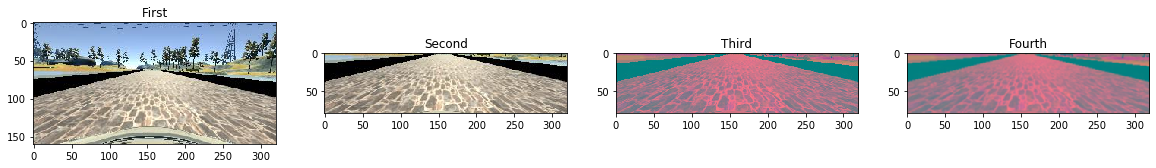

In [19]:
orginal = plt.imread(image_center_path[300])
cropped = crop(image_center_path[300])
yuv_image = convert_2_YUV(cropped)
blur = blur_image(yuv_image)

#Show original image, then after cropping, then after YUV conversion and adding some gaussian blur.
show_four_images(orginal, cropped, yuv_image, blur)


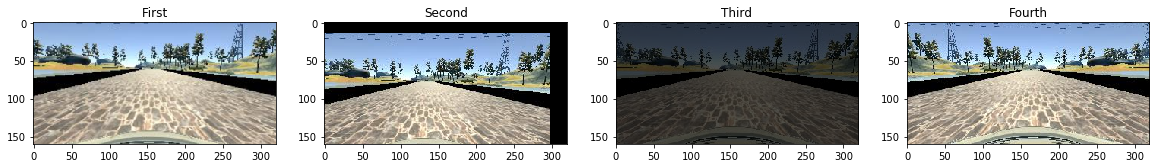

In [20]:
zoom = zoom_image(plt.imread(image_center_path[300]))
pan = pan_image(plt.imread(image_center_path[300]))
bright = random_brightness_image(plt.imread(image_center_path[300]))
flip,_ = random_flip_image(plt.imread(image_center_path[300]), steering_values[300])

#Show zoom image, Random squeeze, random brightness change and flipping image.
show_four_images(zoom, pan, bright, flip)

In [21]:
"""
Wrapper function after adding pipeline for image processing.
1st pipeline has cropping, color space conversion and adding gaussian blur
2nd pipeline randomly apply zoom,Random squeeze, random brightness change.
"""

def process_image(img):
    
    yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    blur_img = cv2.GaussianBlur(yuv_img, (3,3),0)
    
    return blur_img

def add_imgaug(img,str_value):

    img = crop(img)
    i = random.randrange(0, 3)
    if (i <=1):
        img = zoom_image(img)
    elif(i <=2):
        img = pan_image(img)
    elif(i <=3):
        img = random_brightness_image(img)
    
    steering_values_aug.append(str_value)
    return img

In [22]:
"""
Add all left and center images, center and right images and then finally combine above 2 with equal weights.
For initial we take 80% center and 20% for left and right. After this we have 50% for both left center and
right center.
"""
def add_left_right_center_image(left,center,right,steering_value):
    
    img_left = crop(left)
    img_center = crop(center)
    img_right = crop(right)
    
    center_left = cv2.addWeighted(img_center, 0.8, img_left, 0.2, 0)
    center_right = cv2.addWeighted(img_center, 0.8, img_right, 0.2, 0)
    
    center_left_right = cv2.addWeighted(center_left, 0.5, center_left, 0.5, 0)
    
    steering_values_all.append(steering_value)
    
    return center_left_right

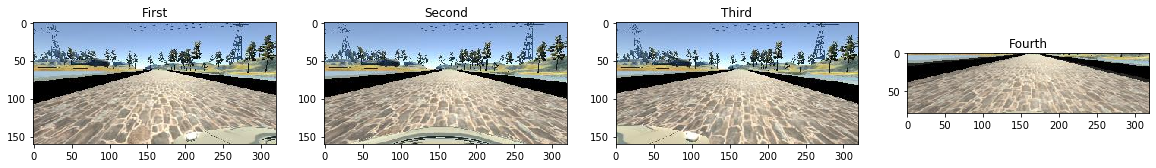

In [23]:
## a image test for add_left_right_center_image, it show left, center, right and final image.

img_test = add_left_right_center_image(image_left_path[9],image_center_path[9],image_right_path[9], steering_values)
show_four_images(plt.imread(image_left_path[9]), plt.imread(image_center_path[9]), plt.imread(image_right_path[9]), img_test)

In [24]:
## apply add_left_right_center_image on selected images and store it in a list

steering_values_all.clear()
added_left_right = list(map(add_left_right_center_image,image_left_path,image_center_path,image_right_path,steering_values))
print(len(added_left_right))
print(len(steering_values_all))

14024
14024


In [25]:
## apply add_imgaug on selected images and store it in a list, for pipline 2

steering_values_aug.clear()
aug_images = list(map(add_imgaug,image_center_path,steering_values))
print(len(aug_images))
print(len(steering_values_aug))

14024
14024


In [26]:
## crop all given images.
original_image_cropped = list(map(crop,image_center_path))
print(len(original_image_cropped))

14024


In [27]:
## Add all the lists i.e combine all images in list after adding all three, random image transformation
## and original image.
all_images_combined = list(chain(added_left_right, aug_images, original_image_cropped)) 
all_steering_combined = list(chain(steering_values_all, steering_values_aug, steering_values)) 

print(len(all_images_combined))
print(len(all_steering_combined))

42072
42072


In [28]:
## Do a train test split, to check model accuracy during traning.
X_train, X_valid, y_train, y_valid = train_test_split(all_images_combined, all_steering_combined, test_size=0.15, random_state=6)

In [29]:
print("Train len {}, valid len {}".format(len(X_train),len(X_valid)))

Train len 35761, valid len 6311


In [30]:
## finally apply pipeline 1 for all processed images before feeding it to model.

X_train_processed = np.array(list(map(process_image,X_train)))
X_valid_processed = np.array(list(map(process_image,X_valid)))
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [31]:
print(X_train_processed.shape)
print(X_valid_processed.shape)
print(len(y_train))
print(len(y_valid))

(35761, 80, 320, 3)
(6311, 80, 320, 3)
35761
6311


In [ ]:
## add optimizer and loss to model. Then train model for 10 epochs 
model.compile(optimizer = 'Adam',loss = 'mse')
history = model.fit(X_train_processed, y_train, epochs=10, validation_data=(X_valid_processed, y_valid))

In [ ]:
## save model.
model.save('process_model_1.h5')

In [ ]:
##plot how trainging went through each epoch
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 2 ( RESNET inspired)

In [9]:
"""
This is identity block of RESNET. This has 3 conv layers each followed by batch normalization
and a acivation function as relu. After this a shortcut is added by adding orignal layer to output of 3rd layer.

This has modification over original RESNET with elu as activation function in conv layers but keep RELU as 
activation after batch normalization.

"""
def identity_block(X, f, filters, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    

    X_shortcut = X
    
    # First component
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid',activation='elu', name = conv_name_base + '2a', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same',activation='elu', name = conv_name_base + '2b', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', activation='elu',name = conv_name_base + '2c', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: add input and above
    X = add([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [10]:
"""
This is Convolution block of RESNET. This has 3 conv layers each followed by batch normalization
and a acivation function as relu. After this a shortcut is added by adding conv of orignal layer to output of 3rd layer.

This has modification over original RESNET with elu as activation function in conv layers but keep RELU as 
activation after batch normalization.

"""

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    

    X_shortcut = X



    # First component 
    X = Conv2D(F1, (1, 1), strides = (s,s), activation='elu',name = conv_name_base + '2a', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', activation='elu',name = conv_name_base + '2b', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

  
    # Third component
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid',activation='elu', name = conv_name_base + '2c', kernel_initializer = "glorot_uniform")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


   # conv of shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid',activation='elu', name = conv_name_base + '1',
                        kernel_initializer = "glorot_uniform")(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: add input conv and layer conv
    X = add([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [11]:
"""
Define model with input as image of shape 80*320.
then add a conv layer with 64 filters of size 7 and strides of 2. This is followed by batch normalization and
relu activation and max pool of kernel 3 and stride of 2.
This is followed by conv block and 2 identity block.
This is followed by conv block and 3 identity block.

This is followed by max pooling and average pooling.

This is followed by 5 FC layers with nodes of 128 in 3 layers followed by 64 and final output layer.
"""

img_input = Input(shape=(80,320,3))

X = ZeroPadding2D((3, 3))(img_input)
# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer="glorot_uniform")(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)
# Stage 2
X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
# Stage 3
X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
X = MaxPooling2D((2,2))(X)
X = AveragePooling2D((2,2), name="max_pool")(X)

X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)

X = Flatten()(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(64, activation='linear', kernel_initializer='glorot_normal')(X)

X = Dense(1, activation='linear',  kernel_initializer = "glorot_uniform")(X)


# Create model
model_1 = Model(inputs = img_input, outputs = X, name='RES')
model_1.summary()

Model: "RES"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 320, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 86, 326, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 160, 64)  9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 40, 160, 64)  256         conv1[0][0]                      
________________________________________________________________________________________________

In [ ]:
## compile model with optimizer and loss.
## train model on same data as earlier model.

model_1.compile(optimizer = 'Adam',loss = 'mse')
print(len(model_1.layers))
history = model_1.fit(X_train_processed, y_train, epochs=10, validation_data=(X_valid_processed, y_valid))

In [ ]:
## save model
model_1.save('process_model_res.h5')

In [ ]:
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## Some more random models to check if there is any improvement

In [172]:
img_input = Input(shape=(80,320,3))

X = ZeroPadding2D((3, 3))(img_input)
# Stage 1
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer="glorot_uniform")(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)
# Stage 2
X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
# Stage 3
X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
X = MaxPooling2D((2,2))(X)
X = AveragePooling2D((2,2), name="max_pool")(X)

X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)

X = Flatten()(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(128, activation='linear', kernel_initializer='glorot_normal')(X)
X = Dense(64, activation='linear', kernel_initializer='glorot_normal')(X)

X = Dense(1, activation='linear',  kernel_initializer = "glorot_uniform")(X)


# Create model
model_2 = Model(inputs = img_input, outputs = X, name='RES')
model_2.summary()

Model: "RES"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 80, 320, 3)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 86, 326, 3)   0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 160, 64)  9472        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 40, 160, 64)  256         conv1[0][0]                      
________________________________________________________________________________________________

In [173]:
added_left_right = np.array(list(map(add_left_right_center_image,image_left_path,image_center_path,image_right_path)))
print(added_left_right.shape)


(15120, 80, 320, 3)


In [174]:
X_train_all, X_valid_all, y_train_all, y_valid_all = train_test_split(added_left_right, steering_values, test_size=0.15, random_state=6)

In [175]:
print(X_train_all.shape)
print(X_valid_all.shape)
print(len(y_train_all))
print(len(y_valid_all))

(12852, 80, 320, 3)
(2268, 80, 320, 3)
12852
2268


In [176]:
X_train_processed_all = np.array(X_train_all)
X_valid_processed_all = np.array(X_valid_all)
y_train_all = np.array(y_train_all)
y_valid_all = np.array(y_valid_all)

model_2.compile(optimizer = 'Adam',loss = 'mse')
#print(len(model_1.layers))
history = model_2.fit(X_train_processed_all, y_train_all, epochs=5, validation_data=(X_valid_processed_all, y_valid_all))

Train on 12852 samples, validate on 2268 samples
Epoch 1/5
12852/12852 [==============================] - 2055s 160ms/sample - loss: 4.4989 - val_loss: 0.0514
Epoch 2/5
12852/12852 [==============================] - 2088s 162ms/sample - loss: 0.0408 - val_loss: 0.0484
Epoch 3/5
12852/12852 [==============================] - 5557s 432ms/sample - loss: 0.0332 - val_loss: 0.0356
Epoch 4/5
12852/12852 [==============================] - 2246s 175ms/sample - loss: 0.0290 - val_loss: 0.0368
Epoch 5/5
12852/12852 [==============================] - 2326s 181ms/sample - loss: 0.0263 - val_loss: 0.0368


In [178]:
model_1.save('default_model_res_1.h5')